In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier



In [41]:
data = pd.read_csv('departures_for_model.csv')

In [42]:
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed


In [4]:
data['status_class'] = data['departure_time_difference'].apply(lambda x: 0 if x < 10 else 1)

In [31]:
# Combine 'date_depart' and 'departure_time_scheduled' into a single column
data['departure_datetime'] = data['date_depart'] + ' ' + data['departure_time_scheduled']
data['departure_datetime'] = pd.to_datetime(data['departure_datetime'], format='%Y-%m-%d %H:%M:%S')

In [33]:
data['date_depart'] = pd.to_datetime(data['date_depart'], format='%Y-%m-%d')

In [35]:
# Define the function to categorize times into the four bins
def time_of_day_category(departure_time):
    if 5 <= departure_time.hour < 9:
        return 1  # Morning (5 AM - 10 PM)
    elif 9 <= departure_time.hour < 13:
        return 2  # Noon (10 PM - 3 PM)
    elif 13 <= departure_time.hour < 18:
        return 3  # Day (3 PM - 7 PM)
    else:
        return 4  # Evening/Night (6 PM - 5 AM)

# Apply the function to the 'departure_datetime' column to create the new column
data['time_of_day_bin'] = data['departure_datetime'].apply(time_of_day_category)


/var/folders/0x/0vrn4bsj03q36gqflgz3f1sh0000gp/T/ipykernel_50229/3948359474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_of_day_bin', y='departure_time_difference', data=time_of_day_sum, palette='viridis')


Text(0.5, 1.0, 'Sum of Departure Time Difference by Time of Day Bins')

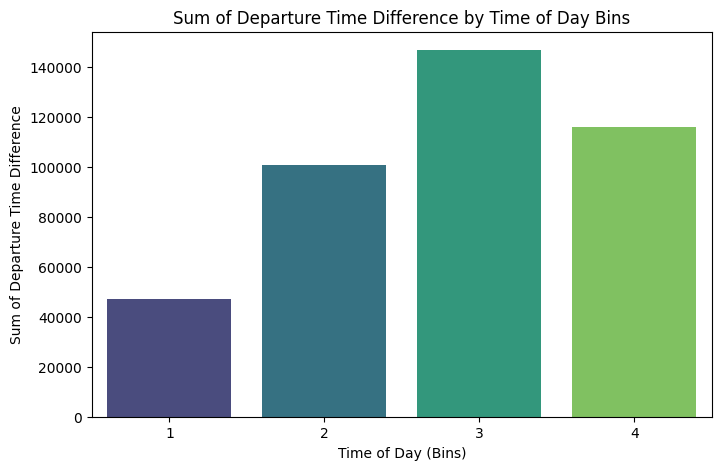

In [8]:
time_of_day_sum = data.groupby('time_of_day_bin')['departure_time_difference'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='time_of_day_bin', y='departure_time_difference', data=time_of_day_sum, palette='viridis')

# Add labels and title
plt.xlabel('Time of Day (Bins)')
plt.ylabel('Sum of Departure Time Difference')
plt.title('Sum of Departure Time Difference by Time of Day Bins')

In [36]:
def extract_time_features(df, date_column):
    df = df.copy()
    df['day'] = pd.to_datetime(df[date_column]).dt.day
    return df

In [37]:
data = extract_time_features(data, 'date_depart')

In [13]:
data.shape

(15190, 17)

MERGERS

In [38]:
average_departure_time_difference = pd.read_csv('features_departures/average_departure_time_difference.csv')
avg_day_airline = pd.read_csv('features_departures/avg_day_airline.csv')
avg_day_destination = pd.read_csv('features_departures/avg_day_destination.csv')
avg_time_airline = pd.read_csv('features_departures/avg_time_airline.csv')
avg_day_airport = pd.read_csv('features_departures/avg_day_airport.csv')

data = pd.merge(data, avg_day_destination, 
                       on=['destination_city', 'day'], 
                       how='left')

data = pd.merge(data, avg_time_airline, 
                       on=['airline', 'time_of_day_bin'], 
                       how='left')

data = pd.merge(data, avg_day_airline, 
                       on=['airline', 'day'], 
                       how='left')

data = pd.merge(data, avg_day_airport, 
                       on=['departure_city', 'day'], 
                       how='left')

data = pd.merge(data, average_departure_time_difference, on='airline', how='left')

### THE CLASSIFIER MODEL

In [22]:
# Define your categorical and numerical columns
categorical_cols = ['airline', 'departure_city', 'destination_city']
numerical_cols = ['average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination']

# Define your preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical features
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_cols),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute numerical features
            ('scaler', StandardScaler())  # Standardize numerical features
        ]), numerical_cols)
    ]
)

# Create and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42))
])

# Split the data
X = data[['airline', 'departure_city', 'destination_city', 'average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination']]
y = data['status_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.45
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate the model with adjusted threshold
print("Adjusted Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("Adjusted Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Adjusted Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))


Adjusted Accuracy: 0.8867676102699145
Adjusted Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1187
           1       0.91      0.90      0.91      1851

    accuracy                           0.89      3038
   macro avg       0.88      0.88      0.88      3038
weighted avg       0.89      0.89      0.89      3038

Adjusted Confusion Matrix:
 [[1028  159]
 [ 185 1666]]


### THE REGRESSOR MODEL

In [24]:
# Select features and target
X = data[['airline', 'departure_city', 'destination_city', 'average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination', 'avg_day_airport']]
y = data['departure_time_difference']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up preprocessing for categorical and numerical columns
categorical_cols = ['airline', 'departure_city', 'destination_city']
numerical_cols = ['average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination', 'avg_day_airport']

# Use ColumnTransformer to apply imputation and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),  # Impute numerical features
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical features
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'  # Ensure that the numerical features are not modified
)

# Build a pipeline with preprocessor and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R² Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 15.387803267832714
R² Score: 0.4096073885479611


### Save the Model

In [23]:
# Save the classifier model to a file
with open('pickled_model/classifier_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as 'classifier_model.pkl'.")


Model saved as 'classifier_model.pkl'.


In [25]:
# Save the classifier model to a file
with open('pickled_model/regressor_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as 'regressor_model.pkl'.")

Model saved as 'regressor_model.pkl'.


### Using the Model

In [5]:
# Load the saved model
with open('pickled_model/classifier_model.pkl', 'rb') as file:
    loaded_classifier_model = pickle.load(file)

print("Classifier model loaded successfully!")

Classifier model loaded successfully!


In [6]:
# Load the saved model
with open('pickled_model/regressor_model.pkl', 'rb') as file:
    loaded_regressor_model = pickle.load(file)

print("Regressor model loaded successfully!")


Regressor model loaded successfully!


### CREATE INPUT DATA

In [2]:
airline = input("Airline: ")
departure_time_scheduled = input("What time, format (xx:xx:xx): ")
date = input("What date format (YYYY-MM-DD): ")
departure_city = input("What city do you fly from: ")
country = input("What country are you flying to: ")
destination_city = input("What city are you flying to: ")

data = {
    'airline': [airline],
    'departure_time_scheduled': [departure_time_scheduled],
    'date_depart': [date],
    'departure_city': [departure_city],
    'country': [country],
    'destination_city': [destination_city]
}

# Convert the dictionary into a pandas DataFrame
validation_data = pd.DataFrame(data)

# View the DataFrame
validation_data

,airline,departure_time_scheduled,date_depart,departure_city,country,destination_city
0,Easyjet,14:25:00,2024-09-21,Berlin,Italy,Milan


In [8]:
validation_data

,airline,departure_time_scheduled,date_depart,departure_city,country,destination_city,departure_datetime,time_of_day_bin,day
0,Easyjet,14:25:00,2024-09-21,Berlin,Italy,Milan,2024-09-21 14:25:00,3,21


### PREDICT

In [7]:
# Example usage:
# Assuming you have your `loaded_classifier_model` and `loaded_regressor_model` ready
processed_validation_data, predictions = process_and_predict_with_regression(validation_data, 
                                                                              loaded_classifier_model, 
                                                                              loaded_regressor_model, 
                                                                              threshold=0.45)

Flight 1, Berlin to Milan: Expect medium delays (10-20 minutes).


## THE PROCESS AND PREDICT FUNCTION

In [4]:
def process_and_predict_with_regression(validation_data, classifier_model, regressor_model, threshold):

    with open('pickled_model/classifier_model.pkl', 'rb') as file:
        loaded_classifier_model = pickle.load(file)
    
    with open('pickled_model/regressor_model.pkl', 'rb') as file:
        loaded_regressor_model = pickle.load(file)

    # Load the necessary CSV files
    average_departure_time_difference = pd.read_csv('features_departures/average_departure_time_difference.csv')
    avg_day_airline = pd.read_csv('features_departures/avg_day_airline.csv')
    avg_day_destination = pd.read_csv('features_departures/avg_day_destination.csv')
    avg_time_airline = pd.read_csv('features_departures/avg_time_airline.csv')
    avg_day_airport = pd.read_csv('features_departures/avg_day_airport.csv')

    # Step 1: Combine 'date_depart' and 'departure_time_scheduled' into a datetime column
    validation_data['departure_datetime'] = validation_data['date_depart'] + ' ' + validation_data['departure_time_scheduled']
    validation_data['departure_datetime'] = pd.to_datetime(validation_data['departure_datetime'], format='%Y-%m-%d %H:%M:%S')

    # Step 2: Convert 'date_depart' to datetime
    validation_data['date_depart'] = pd.to_datetime(validation_data['date_depart'], format='%Y-%m-%d')

    # Step 3: Create 'time_of_day_bin' using the 'departure_datetime' column
    def time_of_day_category(departure_time):
        if 5 <= departure_time.hour < 9:
            return 1  # Morning (5 AM - 9 AM)
        elif 9 <= departure_time.hour < 13:
            return 2  # Noon (9 AM - 1 PM)
        elif 13 <= departure_time.hour < 18:
            return 3  # Afternoon (1 PM - 6 PM)
        else:
            return 4  # Evening/Night (6 PM - 5 AM)

    validation_data['time_of_day_bin'] = validation_data['departure_datetime'].apply(time_of_day_category)

    # Step 4: Extract 'day' from 'date_depart'
    validation_data['day'] = validation_data['date_depart'].dt.day

    # Step 5: Merge with the necessary datasets
    validation_data = pd.merge(validation_data, avg_day_destination, on=['destination_city', 'day'], how='left')
    validation_data = pd.merge(validation_data, avg_time_airline, on=['airline', 'time_of_day_bin'], how='left')
    validation_data = pd.merge(validation_data, avg_day_airline, on=['airline', 'day'], how='left')
    validation_data = pd.merge(validation_data, avg_day_airport, on=['departure_city', 'day'], how='left')
    validation_data = pd.merge(validation_data, average_departure_time_difference, on='airline', how='left')

    # Step 6: Select the required columns for the classifier
    classifier_data = validation_data[['airline', 'departure_city', 'destination_city', 
                                       'average_departure_time_difference', 'avg_time_airline', 
                                       'avg_day_airline', 'avg_day_destination']]

    # Step 7: Use the classifier to predict probabilities and apply the threshold
    y_proba_new = classifier_model.predict_proba(classifier_data)[:, 1]
    y_pred_classifier = (y_proba_new >= threshold).astype(int)

    # Step 8: Iterate through the classifier predictions
    for i, pred in enumerate(y_pred_classifier):
        departure_city = validation_data.iloc[i]['departure_city']
        destination_city = validation_data.iloc[i]['destination_city']
        
        if pred == 1:
            # If a delay is expected (classifier predicted 1), use the regressor to predict delay time
            regressor_data = validation_data[['airline', 'departure_city', 'destination_city', 
                                              'average_departure_time_difference', 'avg_time_airline', 
                                              'avg_day_airline', 'avg_day_destination', 'avg_day_airport']]
            # Ensure the data is a DataFrame with one row (reshape it properly)
            regressor_input = regressor_data.iloc[[i]]  # Double brackets ensure it remains a DataFrame
            delay_pred = regressor_model.predict(regressor_input)

            # Adjust the output based on the delay prediction
            delay_time = delay_pred[0]
            if delay_time < 10:
                print(f"Flight {i+1}, {departure_city} to {destination_city}: Expect short delays.")
            elif delay_time < 20:
                print(f"Flight {i+1}, {departure_city} to {destination_city}: Expect medium delays (10-20 minutes).")
            else:
                print(f"Flight {i+1}, {departure_city} to {destination_city}: Expect long delays.")
        else:
            # If no delay is expected (classifier predicted 0), print a message
            print(f"Flight {i+1}, {departure_city} to {destination_city}: No delays expected.")
    
    # Return the processed validation data and predictions for further inspection if needed
    return validation_data, y_pred_classifier